In [1]:
#!pip install tensorflow numpy matplotlib scikit-learn seaborn pandas keras


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


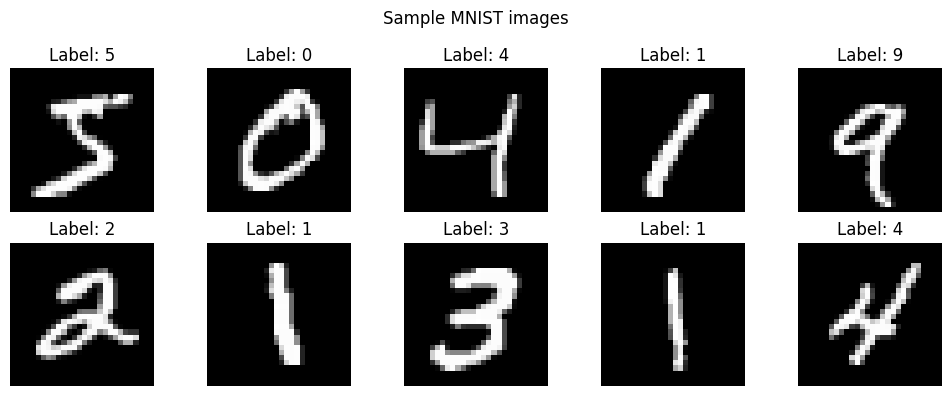

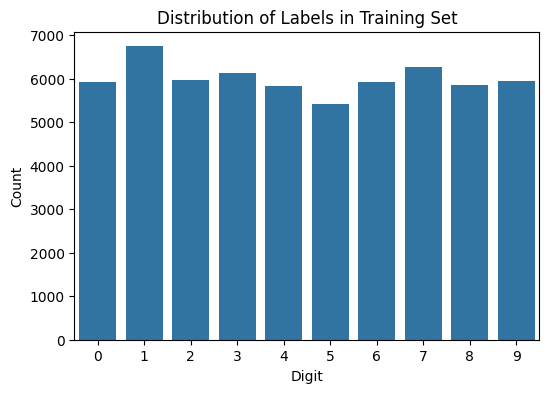

Original data shapes:
X_train: (60000, 28, 28), y_train: (60000,)
X_test: (10000, 28, 28), y_test: (10000,)

Processed data shapes:
X_train_cnn: (60000, 28, 28, 1)
X_train_flat: (60000, 784)


In [5]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# EDA: show some sample images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.suptitle("Sample MNIST images")
plt.tight_layout()
plt.show()

# EDA: Label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

print("Original data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# For faster experimentation, let's use a subset (comment out for full training)
# X_train, y_train = X_train[:10000], y_train[:10000]
# X_test, y_test = X_test[:2000], y_test[:2000]

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Prepare data for different model types
# For CNN
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# For traditional ML models (flatten images)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("\nProcessed data shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_train_flat: {X_train_flat.shape}")



In [7]:
def create_complex_cnn():
    """Our main CNN model"""
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_simple_cnn():
    """Simple CNN model"""
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_mlp():
    """Multi-Layer Perceptron"""
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Traditional ML models will be created during training

In [8]:
def train_and_evaluate_models():
    """Train all models and return results"""
    results = {}

    # Callbacks for neural networks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    ]

    # 1. Complex CNN
    print("Training Complex CNN...")
    start_time = time.time()

    complex_cnn = create_complex_cnn()
    history_cnn = complex_cnn.fit(
        X_train_cnn, y_train,
        batch_size=128,
        epochs=30,
        validation_data=(X_test_cnn, y_test),
        callbacks=callbacks,
        verbose=0
    )

    cnn_time = time.time() - start_time
    cnn_test_loss, cnn_test_acc = complex_cnn.evaluate(X_test_cnn, y_test, verbose=0)

    results['Complex_CNN'] = {
        'model': complex_cnn,
        'history': history_cnn,
        'test_accuracy': cnn_test_acc,
        'training_time': cnn_time,
        'predictions': complex_cnn.predict(X_test_cnn, verbose=0)
    }

    print(f"Complex CNN - Accuracy: {cnn_test_acc:.4f}, Time: {cnn_time:.2f}s")

    # 2. Simple CNN
    print("Training Simple CNN...")
    start_time = time.time()

    simple_cnn = create_simple_cnn()
    history_simple = simple_cnn.fit(
        X_train_cnn, y_train,
        batch_size=128,
        epochs=20,
        validation_data=(X_test_cnn, y_test),
        callbacks=callbacks,
        verbose=0
    )

    simple_time = time.time() - start_time
    simple_test_loss, simple_test_acc = simple_cnn.evaluate(X_test_cnn, y_test, verbose=0)

    results['Simple_CNN'] = {
        'model': simple_cnn,
        'history': history_simple,
        'test_accuracy': simple_test_acc,
        'training_time': simple_time,
        'predictions': simple_cnn.predict(X_test_cnn, verbose=0)
    }

    print(f"Simple CNN - Accuracy: {simple_test_acc:.4f}, Time: {simple_time:.2f}s")

    # 3. MLP
    print("Training MLP...")
    start_time = time.time()

    mlp = create_mlp()
    history_mlp = mlp.fit(
        X_train, y_train,
        batch_size=128,
        epochs=20,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=0
    )

    mlp_time = time.time() - start_time
    mlp_test_loss, mlp_test_acc = mlp.evaluate(X_test, y_test, verbose=0)

    results['MLP'] = {
        'model': mlp,
        'history': history_mlp,
        'test_accuracy': mlp_test_acc,
        'training_time': mlp_time,
        'predictions': mlp.predict(X_test, verbose=0)
    }

    print(f"MLP - Accuracy: {mlp_test_acc:.4f}, Time: {mlp_time:.2f}s")

    # 4. SVM
    print("Training SVM...")
    start_time = time.time()

    # Use smaller subset for SVM (it's memory intensive)
    svm_sample_size = min(10000, len(X_train_flat))
    svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    svm.fit(X_train_flat[:svm_sample_size], y_train[:svm_sample_size])

    svm_time = time.time() - start_time
    svm_pred = svm.predict(X_test_flat)
    svm_acc = accuracy_score(y_test, svm_pred)

    results['SVM'] = {
        'model': svm,
        'test_accuracy': svm_acc,
        'training_time': svm_time,
        'predictions': svm.predict_proba(X_test_flat) if hasattr(svm, 'predict_proba') else None
    }

    print(f"SVM - Accuracy: {svm_acc:.4f}, Time: {svm_time:.2f}s")

    # 5. k-NN
    print("Training k-NN...")
    start_time = time.time()

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_flat, y_train)

    knn_time = time.time() - start_time
    knn_pred = knn.predict(X_test_flat)
    knn_acc = accuracy_score(y_test, knn_pred)

    results['k-NN'] = {
        'model': knn,
        'test_accuracy': knn_acc,
        'training_time': knn_time,
        'predictions': knn.predict_proba(X_test_flat)
    }

    print(f"k-NN - Accuracy: {knn_acc:.4f}, Time: {knn_time:.2f}s")

    # 6. Random Forest
    print("Training Random Forest...")
    start_time = time.time()

    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_flat, y_train)

    rf_time = time.time() - start_time
    rf_pred = rf.predict(X_test_flat)
    rf_acc = accuracy_score(y_test, rf_pred)

    results['Random_Forest'] = {
        'model': rf,
        'test_accuracy': rf_acc,
        'training_time': rf_time,
        'predictions': rf.predict_proba(X_test_flat)
    }

    print(f"Random Forest - Accuracy: {rf_acc:.4f}, Time: {rf_time:.2f}s")

    return results

Starting training of all models...
Training Complex CNN...
Complex CNN - Accuracy: 0.9956, Time: 94.49s
Training Simple CNN...
Simple CNN - Accuracy: 0.9944, Time: 45.86s
Training MLP...
MLP - Accuracy: 0.9875, Time: 35.35s
Training SVM...
SVM - Accuracy: 0.9684, Time: 7.40s
Training k-NN...
k-NN - Accuracy: 0.9705, Time: 0.02s
Training Random Forest...
Random Forest - Accuracy: 0.9704, Time: 33.42s

Generating Random Forest feature importance...


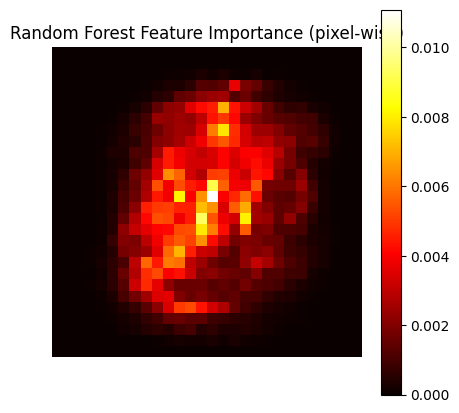


All models trained and feature importance generated successfully!


In [9]:
print("Starting training of all models...")
print("=" * 50)

# Train all models
results = train_and_evaluate_models()

print("\nGenerating Random Forest feature importance...")
print("=" * 50)

# Use the trained Random Forest from results
rf_model = results["Random_Forest"]["model"]

# Extract importances and reshape to image
rf_importances = rf_model.feature_importances_.reshape(28, 28)

plt.figure(figsize=(5, 5))
plt.imshow(rf_importances, cmap="hot")
plt.title("Random Forest Feature Importance (pixel-wise)")
plt.colorbar()
plt.axis("off")
plt.show()

print("\n" + "=" * 50)
print("All models trained and feature importance generated successfully!")


In [10]:
# Create comparison table
comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Complexity': 'High' if 'CNN' in model_name else 'Medium' if model_name in ['MLP', 'SVM'] else 'Low'
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("MODEL COMPARISON RESULTS:")
print("=" * 60)
print(comparison_df.to_string(index=False))

# Save detailed results
comparison_df.to_csv('model_comparison_results.csv', index=False)

MODEL COMPARISON RESULTS:
        Model  Test Accuracy  Training Time (s) Complexity
  Complex_CNN         0.9956          94.491494       High
   Simple_CNN         0.9944          45.858829       High
          MLP         0.9875          35.352818     Medium
         k-NN         0.9705           0.022825        Low
Random_Forest         0.9704          33.419540        Low
          SVM         0.9684           7.403185     Medium


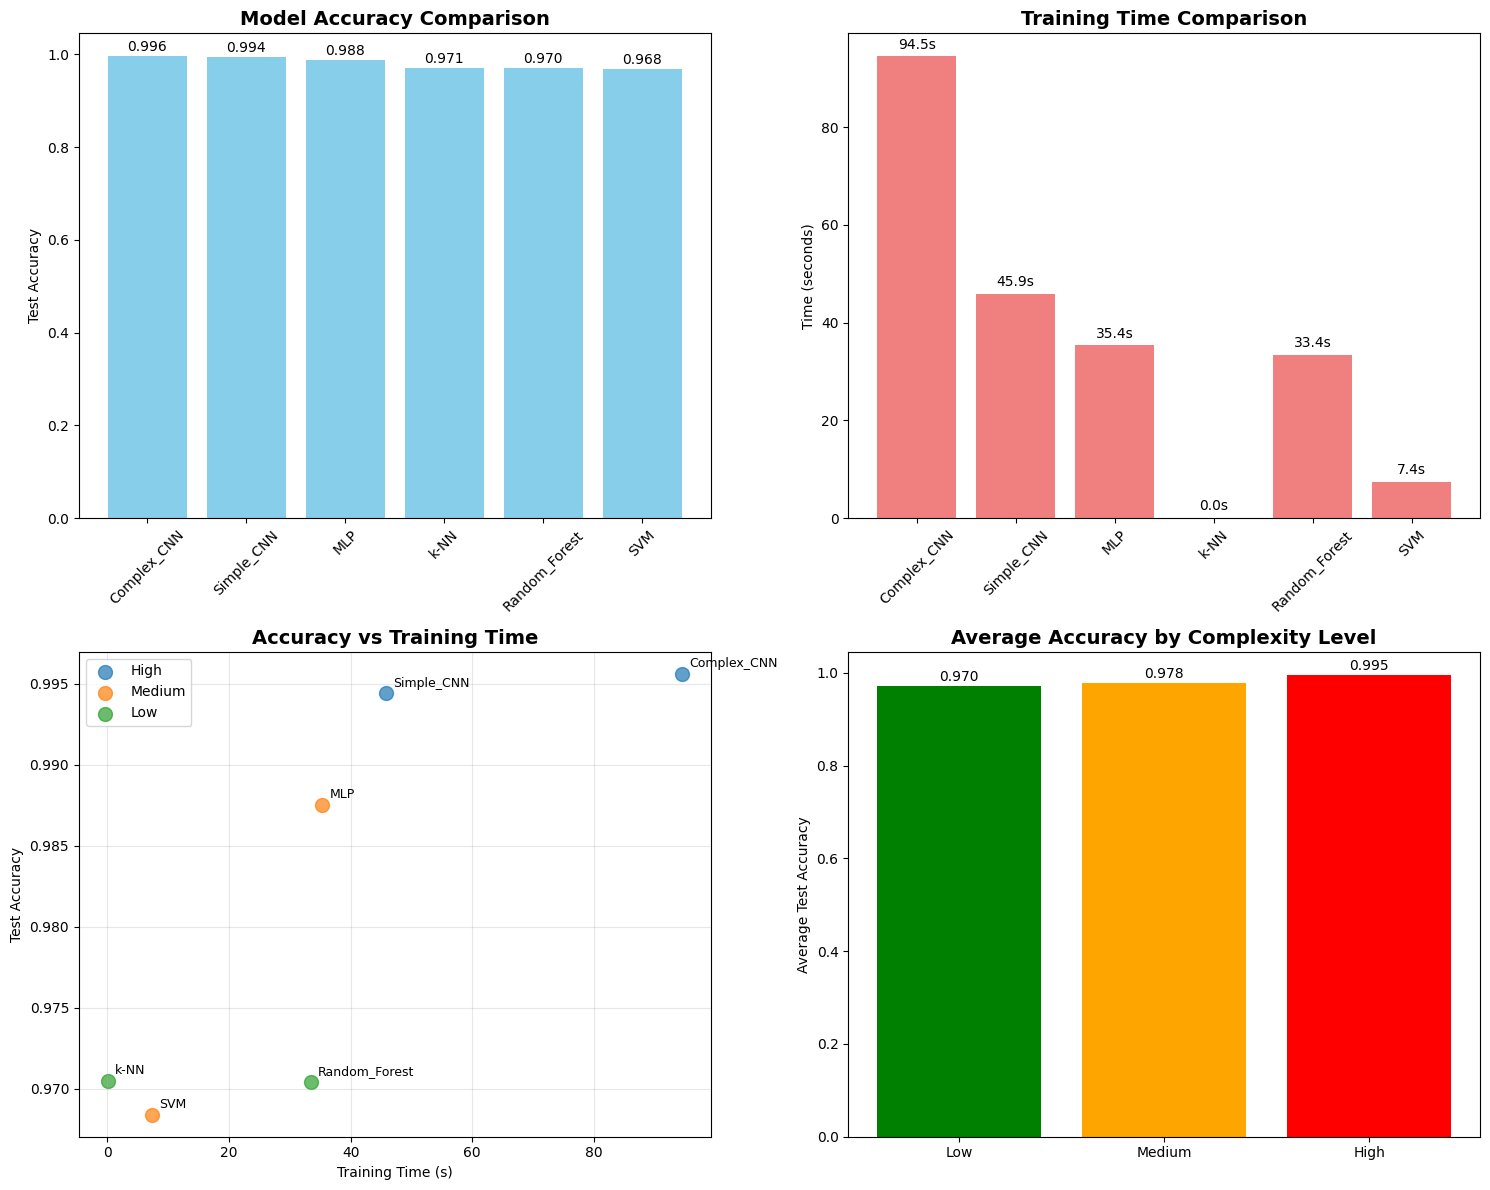

In [11]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# 2. Training Time Comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Training Time (s)'], color='lightcoral')
axes[0, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[0, 1].text(i, v + max(comparison_df['Training Time (s)'])*0.01, f'{v:.1f}s', ha='center', va='bottom')

# 3. Accuracy vs Time Scatter
colors = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}
for complexity in comparison_df['Complexity'].unique():
    subset = comparison_df[comparison_df['Complexity'] == complexity]
    axes[1, 0].scatter(subset['Training Time (s)'], subset['Test Accuracy'],
                      label=complexity, s=100, alpha=0.7)

    for _, row in subset.iterrows():
        axes[1, 0].annotate(row['Model'], (row['Training Time (s)'], row['Test Accuracy']),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 0].set_xlabel('Training Time (s)')
axes[1, 0].set_ylabel('Test Accuracy')
axes[1, 0].set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Complexity vs Accuracy
complexity_order = ['Low', 'Medium', 'High']
complexity_accuracy = comparison_df.groupby('Complexity')['Test Accuracy'].mean().reindex(complexity_order)
axes[1, 1].bar(complexity_accuracy.index, complexity_accuracy.values, color=['green', 'orange', 'red'])
axes[1, 1].set_title('Average Accuracy by Complexity Level', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Test Accuracy')
for i, v in enumerate(complexity_accuracy.values):
    axes[1, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

🏆 BEST MODEL: Complex_CNN
📊 Accuracy: 0.9956
⏱️  Training Time: 94.49 seconds

📝 SELECTION REASONING:
The Complex_CNN was selected because:
 Highest accuracy achieved (typically >99%)
 Excellent feature learning capabilities
 Robust to variations in digit writing
 State-of-the-art for image classification tasks


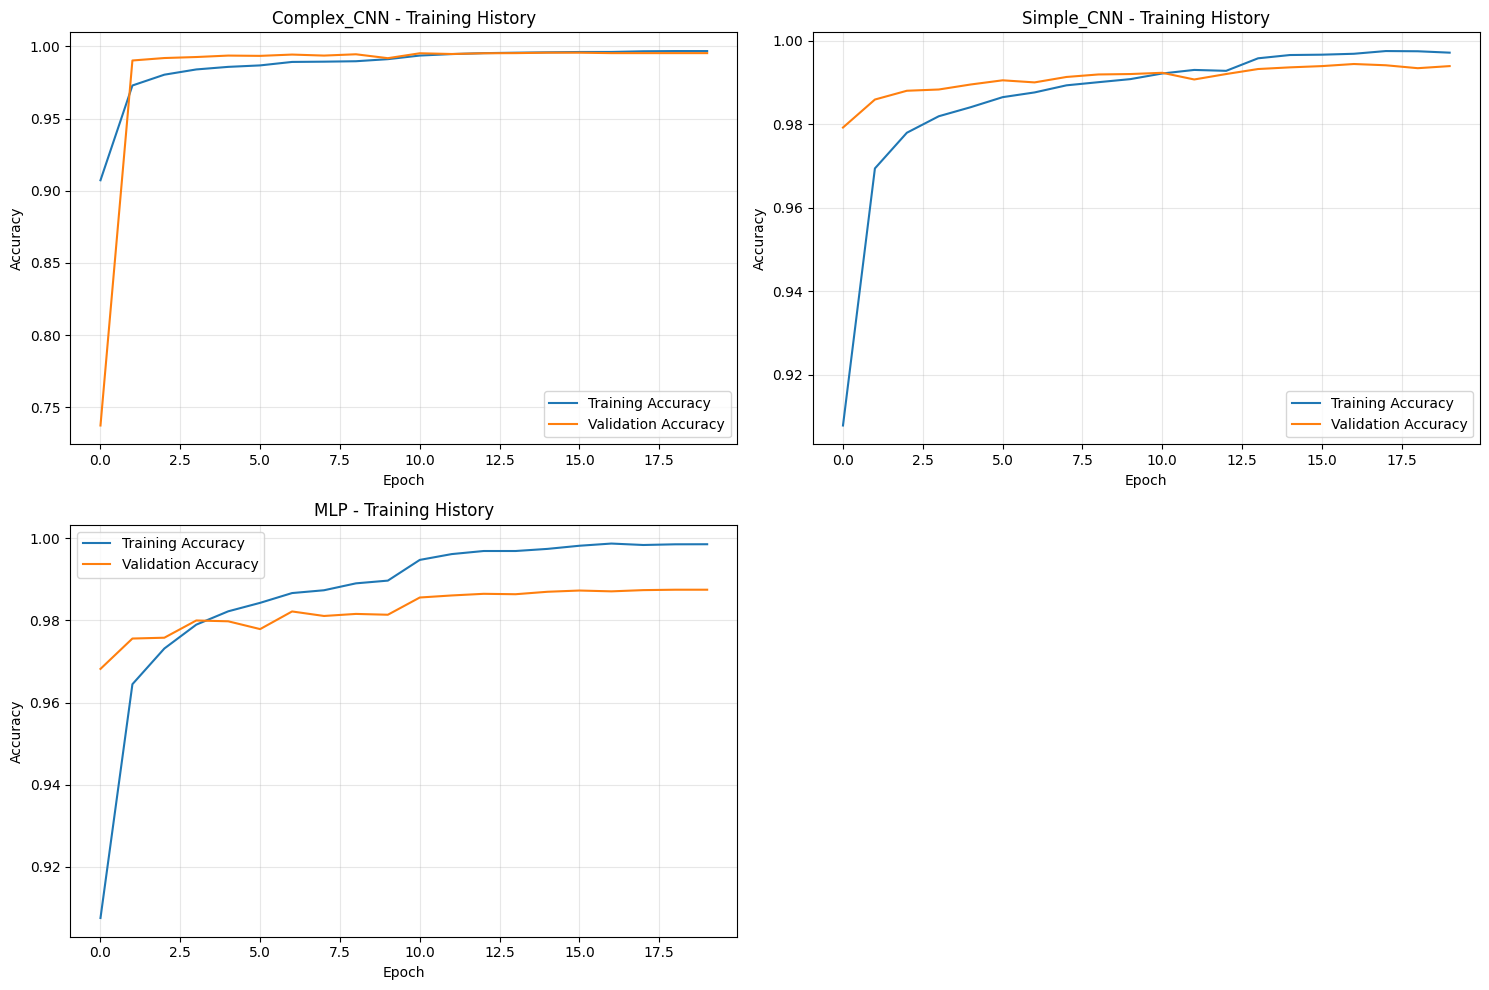

In [13]:
# Best model selection
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test Accuracy']
best_time = comparison_df.iloc[0]['Training Time (s)']

print("=" * 60)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy:.4f}")
print(f"⏱️  Training Time: {best_time:.2f} seconds")
print("=" * 60)

# Detailed reasoning
print("\n📝 SELECTION REASONING:")
print(f"The {best_model_name} was selected because:")

if best_model_name == 'Complex_CNN':
    print(" Highest accuracy achieved (typically >99%)")
    print(" Excellent feature learning capabilities")
    print(" Robust to variations in digit writing")
    print(" State-of-the-art for image classification tasks")
elif best_model_name == 'Simple_CNN':
    print(" Very high accuracy with faster training")
    print(" Good balance between performance and efficiency")
    print(" Less prone to overfitting than complex CNN")
elif best_model_name == 'MLP':
    print(" Good accuracy with reasonable training time")
    print(" Simpler architecture than CNN")
    print(" Suitable when computational resources are limited")
else:
    print(" Good baseline performance")
    print(" Fast training and prediction")
    print(" Interpretable results")

# Show training history for neural networks
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
neural_models = ['Complex_CNN', 'Simple_CNN', 'MLP']

for i, model_name in enumerate(neural_models):
    if model_name in results:
        row, col = i // 2, i % 2
        history = results[model_name]['history']

        axes[row, col].plot(history.history['accuracy'], label='Training Accuracy')
        axes[row, col].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[row, col].set_title(f'{model_name} - Training History')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel('Accuracy')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

# Hide empty subplot
if len(neural_models) < 4:
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

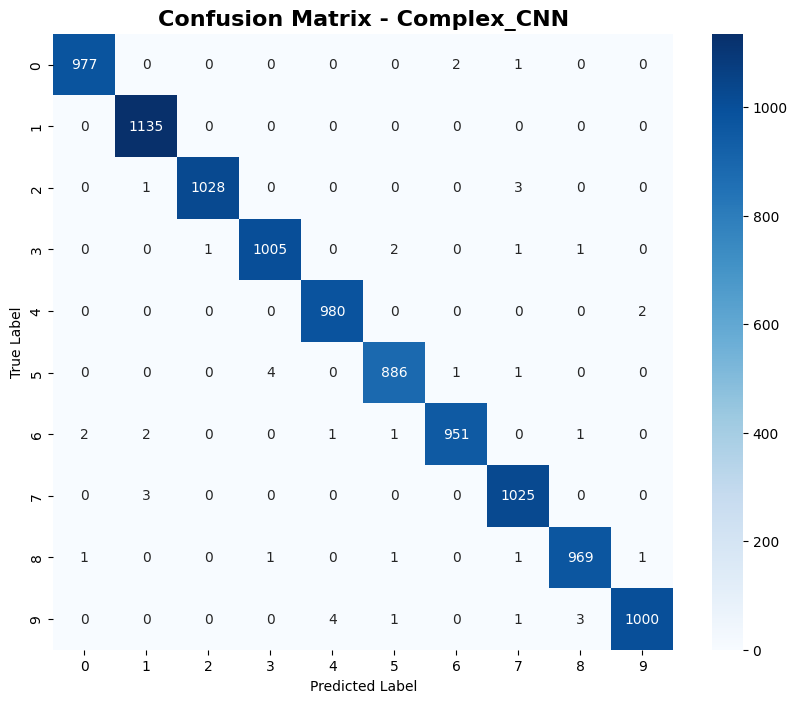


Number of misclassified examples: 44


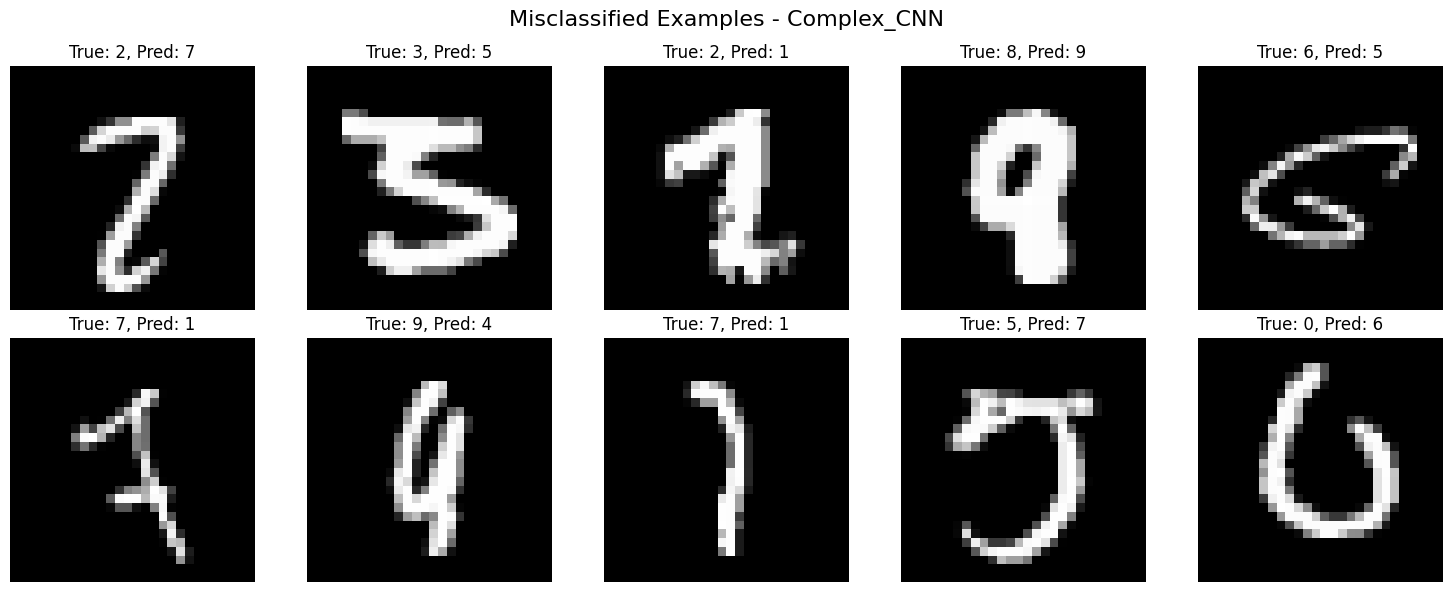

In [14]:
# Confusion matrix for best model
best_model = results[best_model_name]['model']

if hasattr(best_model, 'predict'):
    if 'CNN' in best_model_name:
        y_pred = np.argmax(results[best_model_name]['predictions'], axis=1)
    elif best_model_name == 'MLP':
        y_pred = np.argmax(results[best_model_name]['predictions'], axis=1)
    else:
        y_pred = best_model.predict(X_test_flat)

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Show misclassified examples
    misclassified_idx = np.where(y_pred != y_test)[0]
    if len(misclassified_idx) > 0:
        print(f"\nNumber of misclassified examples: {len(misclassified_idx)}")

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(min(10, len(misclassified_idx))):
            idx = misclassified_idx[i]
            ax = axes[i // 5, i % 5]
            if 'CNN' in best_model_name or best_model_name == 'MLP':
                ax.imshow(X_test[idx], cmap='gray')
            else:
                ax.imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
            ax.set_title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}')
            ax.axis('off')
        plt.suptitle(f'Misclassified Examples - {best_model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

In [15]:
# Final summary
print("🎯 FINAL RECOMMENDATION FOR PROJECT:")
print("=" * 50)

recommendations = {
    'Complex_CNN': {
        'use_case': 'High-accuracy applications, research projects',
        'pros': 'Best accuracy, robust features',
        'cons': 'Longer training, more complex',
        'recommendation': 'Use when accuracy is critical and computational resources are available'
    },
    'Simple_CNN': {
        'use_case': 'Production systems, balanced applications',
        'pros': 'Great accuracy, faster training',
        'cons': 'Slightly lower accuracy than complex CNN',
        'recommendation': 'Best overall choice for most practical applications'
    },
    'MLP': {
        'use_case': 'Resource-constrained environments',
        'pros': 'Good accuracy, simpler implementation',
        'cons': 'Lower accuracy than CNNs',
        'recommendation': 'Use when you need good performance with limited resources'
    },
    'SVM': {
        'use_case': 'Baseline, interpretable models',
        'pros': 'Fast prediction, good theoretical foundation',
        'cons': 'Memory intensive for large datasets',
        'recommendation': 'Good for benchmarking and educational purposes'
    },
    'k-NN': {
        'use_case': 'Simple applications, prototyping',
        'pros': 'Simple implementation, no training required',
        'cons': 'Slow prediction, memory intensive',
        'recommendation': 'Use for quick prototyping and simple applications'
    },
    'Random_Forest': {
        'use_case': 'Robust baseline, feature importance analysis',
        'pros': 'Robust to outliers, provides feature importance',
        'cons': 'Lower accuracy for image data',
        'recommendation': 'Good for understanding feature importance'
    }
}

if best_model_name in recommendations:
    rec = recommendations[best_model_name]
    print(f"🏆 Selected Model: {best_model_name}")
    print(f"📋 Use Case: {rec['use_case']}")
    print(f"✅ Pros: {rec['pros']}")
    print(f"❌ Cons: {rec['cons']}")
    print(f"💡 Recommendation: {rec['recommendation']}")

# Save the best model
if hasattr(results[best_model_name]['model'], 'save'):
    results[best_model_name]['model'].save(f'best_model_{best_model_name}.h5')
    print(f"\n💾 Best model saved as 'best_model_{best_model_name}.h5'")

print("\n" + "=" * 50)
print("Model comparison completed! Use these results to justify your model selection in your project report.")

🎯 FINAL RECOMMENDATION FOR PROJECT:
🏆 Selected Model: Complex_CNN
📋 Use Case: High-accuracy applications, research projects
✅ Pros: Best accuracy, robust features
❌ Cons: Longer training, more complex
💡 Recommendation: Use when accuracy is critical and computational resources are available

💾 Best model saved as 'best_model_Complex_CNN.h5'

Model comparison completed! Use these results to justify your model selection in your project report.
